In [213]:
import numpy as np

In [214]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# %matplotlib tk
we_keys = [0, 10, -1]
eff_keys = [0, 0.2, 0.6, 1]
db_keys = [0, 1, 10, 100]

# Create a dictionary dict with all the policies like dict[we][db][eff] = policy
"""large_policies = {
    we: {eff: {db: np.zeros((5,2)) for db in db_keys} for eff in eff_keys} for we in we_keys
}

large_policies[10][0][0] = np.array([[-493.255, 0. ], [-491.795, 0. ], [-484.36, 0. ], [-482.56, 0. ], [-490.73, 0. ]])
large_policies[10][0][1] = np.array([[-493.255,0.],[-491.795,0.],[-484.36,0.  ],[-482.56,0.  ],[-490.73,0.  ]])
large_policies[10][0][10] =  np.array([[-493.515,0.],[-494.93,0.  ],[-494.14,0.  ],[-494.685,0.],[-494.33,0.  ]])
large_policies[10][0][100] =  np.array([[-493.515,0.],[-494.93,0.  ],[-494.14,0.  ],[-494.685,0.],[-494.33,0.  ]])
large_policies[10][0.2][0] =  np.array([[-159.21,0.  ],[-495.405,0.],[-487.79,0.  ],[-487.555,0.],[-495.415,0.]])
large_policies[10][0.2][1] =  np.array([[-135.99  , 31.2263], [-379.166,  0. ], [-473.507,  0. ], [-371.311,  0. ], [-431.127,  0. ]])
large_policies[10][0.2][10] =  np.array([[-141.003 ,   34.7508], [-379.329,    0.   ], [-393.191 ,    0.7707], [-396.253 ,    0.5138], [-394.567 ,    0.5306]])
large_policies[10][0.2][100] =  np.array([[-148.09,40.852],[-410.19,0.  ],[-419.235,0.],[-387.675,0.],[-417.115,0.]])
large_policies[10][0.6][0] =  np.array([[-205.586,  0. ], [-285.879,  0. ], [-278.435,  0. ], [-495.237,  0. ], [-495.861,  0. ]])
large_policies[10][0.6][1] =  np.array([[-151.564 ,    5.3354],[-105.249 ,    9.2631], [-146.008 ,    6.4743], [-2.51422e+02,  1.33000e-02], [-2.40726e+02,  3.43000e-02]])
large_policies[10][0.6][10] =  np.array([[-152.914 ,   10.3453], [-154.314 ,   10.7275], [-175.09  ,    8.2922], [-2.76137e+02, -1.00000e-03], [-297.847,    0.   ]])
large_policies[10][0.6][100] =  np.array([[-161.36,27.86],[-173.88,25.97],[-172.64,25.466],[-242.74,0.],[-319.92, 0.  ]])
large_policies[10][1][0] =  np.array([])
large_policies[10][1][1] =  np.array([])
large_policies[10][1][10] =  np.array([])
large_policies[10][1][100] =  np.array([])
large_policies[10][1][100] =  np.array([])
large_policies[0][0.2][0] =  np.array([[-68.607,  -5.984], [-495.719,    0.   ], [-4.95445e+02, -1.10000e-02], [-4.9547e+02, -1.0000e-03], [-495.773,    0.   ]])
large_policies[0][0.2][1] =  np.array([[-68.607,  -5.984], [-495.719,    0.   ], [-4.95445e+02, -1.10000e-02], [-4.9547e+02, -1.0000e-03], [-495.773,    0.   ]])
large_policies[0][0.2][10] =  np.array([[-68.607,  -5.984], [-495.719,    0.   ], [-4.95445e+02, -1.10000e-02], [-4.9547e+02, -1.0000e-03], [-495.773,    0.   ]])
large_policies[0][0.2][100] =  np.array([[-68.607,  -5.984], [-495.719,    0.   ], [-4.95445e+02, -1.10000e-02], [-4.9547e+02, -1.0000e-03], [-495.773,    0.   ]])
large_policies[0][0.6][0] =  np.array([[-1.05702e+02, -8.80000e-02], [-117.767,   -2.734], [-136.136,   -0.833], [-498.195,    0.   ], [-498.261,    0.   ]])
large_policies[0][0.6][1] =  np.array([[-1.05702e+02, -8.80000e-02], [-117.767,   -2.734], [-136.136,   -0.833], [-498.195,    0.   ], [-498.261,    0.   ]])
large_policies[0][0.6][10] =  np.array([[-1.05702e+02, -8.80000e-02], [-117.767,   -2.734], [-136.136,   -0.833], [-498.195,    0.   ], [-498.261,    0.   ]])
large_policies[0][0.6][100] =  np.array([[-1.05702e+02, -8.80000e-02], [-117.767,   -2.734], [-136.136,   -0.833], [-498.195,    0.   ], [-498.261,    0.   ]])

# Any policy with we = 0 is the same as the policy with we = 10 and db = 0
for eff in eff_keys:
    for db in db_keys:
        # if empty, copy the policy with we = 10 and db = 0
        if len(large_policies[0][eff][db]) == 0 or (large_policies[0][eff][db] == np.zeros((5,2))).all():
            large_policies[0][eff][db] = large_policies[10][eff][0]"""



'large_policies = {\n    we: {eff: {db: np.zeros((5,2)) for db in db_keys} for eff in eff_keys} for we in we_keys\n}\n\nlarge_policies[10][0][0] = np.array([[-493.255, 0. ], [-491.795, 0. ], [-484.36, 0. ], [-482.56, 0. ], [-490.73, 0. ]])\nlarge_policies[10][0][1] = np.array([[-493.255,0.],[-491.795,0.],[-484.36,0.  ],[-482.56,0.  ],[-490.73,0.  ]])\nlarge_policies[10][0][10] =  np.array([[-493.515,0.],[-494.93,0.  ],[-494.14,0.  ],[-494.685,0.],[-494.33,0.  ]])\nlarge_policies[10][0][100] =  np.array([[-493.515,0.],[-494.93,0.  ],[-494.14,0.  ],[-494.685,0.],[-494.33,0.  ]])\nlarge_policies[10][0.2][0] =  np.array([[-159.21,0.  ],[-495.405,0.],[-487.79,0.  ],[-487.555,0.],[-495.415,0.]])\nlarge_policies[10][0.2][1] =  np.array([[-135.99  , 31.2263], [-379.166,  0. ], [-473.507,  0. ], [-371.311,  0. ], [-431.127,  0. ]])\nlarge_policies[10][0.2][10] =  np.array([[-141.003 ,   34.7508], [-379.329,    0.   ], [-393.191 ,    0.7707], [-396.253 ,    0.5138], [-394.567 ,    0.5306]])\nlar

In [215]:
import pandas as pd

# Dataframe from csv
df = pd.read_csv("EGG_DATA/report.csv")
df["dir"] = df["dir"].apply(lambda x: int(x))
# Time to survival -1 to inf
for i in range(5):
    df[f"time_to_survival_agent_{i}"] = df[f"time_to_survival_agent_{i}"].apply(lambda x: np.infty if x == -1 else x)
    df[f"time_to_survival_agent_sd{i}"] = df[f"time_to_survival_agent_sd{i}"].apply(lambda x: np.infty if x == -1 else x)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   db                          17 non-null     float64
 1   eff_rate                    17 non-null     float64
 2   we                          17 non-null     float64
 3   dir                         17 non-null     int64  
 4   mean_reward                 17 non-null     float64
 5   mean_reward_agent_0         17 non-null     float64
 6   mean_reward_agent_1         17 non-null     float64
 7   mean_reward_agent_2         17 non-null     float64
 8   mean_reward_agent_3         17 non-null     float64
 9   mean_reward_agent_4         17 non-null     float64
 10  mean_mo_reward_agent_v0_0   17 non-null     float64
 11  mean_mo_reward_agent_v0_1   17 non-null     float64
 12  mean_mo_reward_agent_v0_2   17 non-null     float64
 13  mean_mo_reward_agent_v0_3   17 non-nu

In [216]:
# Pretty print table with eff, db, we and dir
df[["eff_rate", "db", "we", "dir"]]

,eff_rate,db,we,dir
0,0.2,0.0,10.0,0
1,0.2,0.0,0.0,0
2,0.6,0.0,10.0,4
3,0.6,0.0,0.0,2
4,1.0,0.0,10.0,1
5,0.0,1.0,10.0,0
6,0.2,1.0,10.0,3
7,0.6,1.0,10.0,1
8,1.0,1.0,10.0,0
9,0.0,10.0,10.0,0


In [217]:
df_numpy = df.to_numpy()

# Reference policies: we = 10
ref_policies_values = {
    eff: {db: np.zeros((5,2)) for db in db_keys} for eff in eff_keys
}
ref_policies_np = df_numpy[df_numpy[:, 2] == 10]

for i in range(len(ref_policies_np)):
    eff = ref_policies_np[i][1]
    db = ref_policies_np[i][0]
    ref_policies_values[eff][db] = np.hstack([ref_policies_np[i][10:15].reshape((5,1)), ref_policies_np[i][15:20].reshape((5,1)) ])

ref_policies_values[0.6][1] = np.array([[-1.3750e+02,  7.3400e+00],[-1.3025e+02,  5.2600e+00],[-1.3400e+02,  7.1700e+00],[-2.5138e+02,  1.0000e-02],[-2.4075e+02,  3.0000e-02]])   

ref_policies_values[0.2][1]

array([[-136.  ,   31.23],
       [-379.25,    0.  ],
       [-473.5 ,    0.  ],
       [-371.25,    0.  ],
       [-431.25,    0.  ]])

In [218]:
ref_policies_values[0.6][1]

array([[-1.3750e+02,  7.3400e+00],
       [-1.3025e+02,  5.2600e+00],
       [-1.3400e+02,  7.1700e+00],
       [-2.5138e+02,  1.0000e-02],
       [-2.4075e+02,  3.0000e-02]])

In [219]:
unet_policies_values = {
    eff: np.zeros((5,2)) for eff in eff_keys
}

unet_policies_np = df_numpy[df_numpy[:, 2] == 0]
for i in range(len(unet_policies_np)):
    eff = unet_policies_np[i][1]
    unet_policies_values[eff] = np.hstack([unet_policies_np[i][10:15].reshape((5,1)), unet_policies_np[i][15:20].reshape((5,1)) ])
unet_policies_values[0] = ref_policies_values[0][0]
unet_policies_values[1] = ref_policies_values[1][0]
unet_policies_values[0.6]

array([[-1.0044e+02, -3.0000e-02],
       [-1.1306e+02, -6.1000e-01],
       [-1.4475e+02, -1.7200e+00],
       [-4.9800e+02,  0.0000e+00],
       [-4.9825e+02,  0.0000e+00]])

In [220]:
# Function to get the intersection of two lines represented as f(we) = v0 + we*ve for a two given fixed sets of (v0, ve)
def get_intersection(v01, ve1, v02, ve2):
    if ve1 == ve2:
        return 0
    we = (v01 - v02) / (ve2 - ve1)
    return we
# get_intersection(mo_value_w10[2][0], mo_value_w10[2][1], mo_value_w0[2][0], mo_value_w0[2][1])

3.4599891126837234
2.2370773416245626
0.2943100065402224
-112.49999999999999
-126.2766990291262


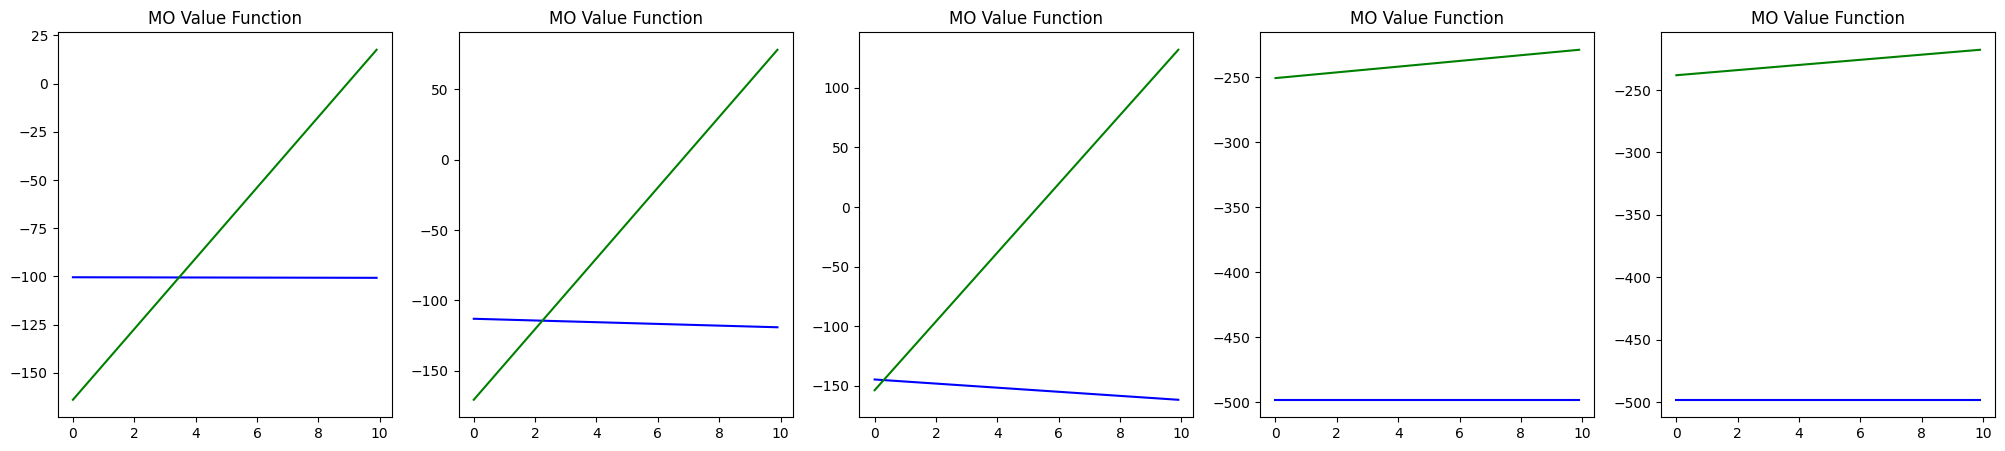

In [221]:
# Plot values as function of weight w that scales the reward
fig, axs = plt.subplots(1, 5, figsize=(25, 5)) 
step = 0.1
# for ag in mo_value_w10:
max_weight = 10
# Subplot for each agent
x = np.arange(0, max_weight, step)
w = np.array([np.ones(int(max_weight/step)), np.arange(0, max_weight, step)])

setting = {"eff": 0.6, "db": 100}
for ag in range(5):
    axs[ag].set_title("MO Value Function")
    ref = ref_policies_values[setting["eff"]][setting["db"]]
    unet = unet_policies_values[setting["eff"]]
    axs[ag].plot(x, np.dot(unet[ag], w), c="blue")
    axs[ag].plot(x, np.dot(ref[ag], w), c="green")
    
wes = []
for ag in range(5):
    # Print intersecctions
    p1 = unet_policies_values[setting["eff"]][ag]
    p2 = ref_policies_values[setting["eff"]][setting["db"]][ag]
    inter = get_intersection(p1[0], p1[1], p2[0], p2[1])
    print(inter)
    wes.append(inter)
plt.show()

In [222]:
def compute_wes_prima(eff, db):
    def aggregation_function(wes, method="median"):
        # cut to interval 1-10 else return -inf
        wes = [w for w in wes if w >= 1 and w <= 10]
        if len(wes) == 0:
            return -np.infty
        if method == "median":
            return np.median(wes)
        if method == "mean":
            return np.mean(wes)
        if method == "max":
            return np.max(wes)
        if method == "min":
            return np.min(wes)
    wes_prima = []
    for ag in range(5):
        # Print intersecctions
        p1 = unet_policies_values[eff][ag]
        p2 = ref_policies_values[eff][db][ag]
        inter = get_intersection(p1[0], p1[1], p2[0], p2[1])
        wes_prima.append(inter)
    return aggregation_function(wes_prima, method="median")

# Create table of WES' for each eff (from 0.2, 0.6, 1) and db (from 0, 1, 10, 100) 
wes_prima = {
    db: {eff: compute_wes_prima(eff, db) for eff in eff_keys} for db in db_keys
}
# pretty print as dataframe
pd.DataFrame(wes_prima)

,0,1,10,100
0.0,-inf,-inf,-inf,-inf
0.2,-inf,1.808922,1.629001,1.884186
0.6,-inf,3.978472,1.107292,2.848533
1.0,-inf,-inf,8.145594,4.619191


In [223]:
time2survival_np = ref_policies_np[:, 20:25]
time2survival_std_np = ref_policies_np[:, 25:30]
# Create a string with the mean and std of the time to survival for each agent
mean_std_time2survival = {(eff, db): [] for eff in eff_keys for db in db_keys}
for i in range(len(time2survival_np)):
    eff = ref_policies_np[i][1]
    db = ref_policies_np[i][0]
    for ag in range(5):
        mean_std_time2survival[eff, db].append(f"{time2survival_np[i][ag]:.2f} ± {time2survival_std_np[i][ag]:.2f}")
# pretty print as dataframe
mean_std_time2survival[0, 10]

['0.72 ± 27.27',
 '-0.18 ± 18.53',
 '0.42 ± 25.86',
 '1.28 ± 32.44',
 '0.44 ± 26.28']

In [233]:
# Print table of the gini
max_gini_value = 1 - 1/5
gini = {
    db: {eff: df[(df['we'] == 10) & (df['eff_rate'] == eff) & (df['db'] == db)]["gini"].to_numpy()/max_gini_value for eff in eff_keys} for db in db_keys
}
pd.DataFrame(gini)

,0,1,10,100
0.0,[],[0.95],[0.95],[0.9375]
0.2,[0.6],[0.95],[1.0],[0.9875]
0.6,[0.825],[0.95],[0.95],[1.0]
1.0,[0.975],[0.95],[0.9875],[1.0]


In [236]:
# Print table of the hoover
max_hoover_value = 1
hoover = {
    db: {eff: df[(df['we'] == 10) & (df['eff_rate'] == eff) & (df['db'] == db)]["hoover"].to_numpy() for eff in eff_keys} for db in db_keys
}
pd.DataFrame(hoover).to_numpy()

array([[array([], dtype=float64), array([0.18]), array([0.18]),
        array([0.2])],
       [array([0.48]), array([0.15]), array([0.02]), array([0.05])],
       [array([0.35]), array([0.2]), array([0.19]), array([0.])],
       [array([0.11]), array([0.18]), array([0.1]), array([0.])]],
      dtype=object)

In [238]:
import numpy as np
from tabulate import tabulate

gini = np.array([[np.array([], dtype=np.float64), np.array([0.18]), np.array([0.18]),
        np.array([0.2])],
       [np.array([0.48]), np.array([0.15]), np.array([0.02]), np.array([0.05])],
       [np.array([0.35]), np.array([0.2]), np.array([0.19]), np.array([0.])],
       [np.array([0.11]), np.array([0.18]), np.array([0.1]), np.array([0.])]],
      dtype=object)

def numpy_to_latex(array):    
    latex_table = tabulate(array, tablefmt="latex_raw", headers=db_keys, showindex=eff_keys)
    return latex_table

print(numpy_to_latex(gini))

\begin{tabular}{rlrrr}
\hline
     & 0      &    1 &   10 &   100 \\
\hline
 0   & []     & 0.18 & 0.18 &  0.2  \\
 0.2 & [0.48] & 0.15 & 0.02 &  0.05 \\
 0.6 & [0.35] & 0.2  & 0.19 &  0    \\
 1   & [0.11] & 0.18 & 0.1  &  0    \\
\hline
\end{tabular}
